# RKD Artists

## Number of female artists

The query below selects all artists from the 19th century. Can you also select all the artists from the 18th century?

In [23]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint = 'https://api.data.netwerkdigitaalerfgoed.nl/datasets/rkd/rkdartists/services/rkdartists-jena/sparql'
query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rkdo: <http://data.rkd.nl/def#>
PREFIX schema: <http://schema.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?id ?name ?gender ?date_birth ?date_death

WHERE {
?id a schema:Person .
?id schema:name ?name .
?id schema:gender ?gender .
?id rkdo:Birth ?birth .
OPTIONAL {
    ?birth schema:startDate ?date_birth . } .
?id rkdo:Death ?death .
OPTIONAL {
    ?death schema:startDate ?date_death . } .
    
FILTER ( ?date_birth >= "1800-01-01"^^xsd:date && ?date_birth < "1900-01-01"^^xsd:date)

}
ORDER BY ?name
"""


sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
data = sparql.query().convert()


In [17]:
import pandas as pd
import numpy as np 

df = pd.json_normalize(data['results']['bindings'])   

print( f'There are {df.shape[0]} artists in this dataset.' )

## add column 'decade'
df['year'] = pd.DatetimeIndex(df['date_birth.value']).year
df['decade'] = df['year'] / 10
df['decade'] = np.floor(df['decade']).astype(int) * 10


female = df[ df['gender.value'] == 'http://schema.org/Female']
male = df[ df['gender.value'] == 'http://schema.org/Male']


print( f'There are {female.shape[0]} female artists and {male.shape[0]} male artists in this dataset.' )

counts = female.groupby('decade').size()
counts = counts.to_frame()


There are 31162 artists in this dataset.
There are 2972 female artists and 28187 male artists in this dataset.


In [31]:
max = 10

female.reset_index(drop=True)

for index,row in female.iterrows():
    print(index)
    print(row['name.value'])
    print(row['id.value'])
    if index == max:
        break

7
Louise (Queen of Denmark)
https://data.rkd.nl/artists/275368
10
Victoria (Queen of Great-Britain and Ireland)
https://data.rkd.nl/artists/80887
11
Wilhelmina (Queen of the Netherlands)
https://data.rkd.nl/artists/84533
16
Aafjes, Sijtje
https://data.rkd.nl/artists/15
19
Aagen Moro, Tai
https://data.rkd.nl/artists/126561
25
Aarem, Pauline van
https://data.rkd.nl/artists/58
40
Abbott, Berenice
https://data.rkd.nl/artists/124341
42
Abbéma, Louise
https://data.rkd.nl/artists/122
49
Abeleven, Henrica
https://data.rkd.nl/artists/112023
51
Abeloos, Sonia
https://data.rkd.nl/artists/184
56
Abels-d'Albert, Erika
https://data.rkd.nl/artists/341242
57
Abels-van Os, Cornelia Johanna
https://data.rkd.nl/artists/492508
67
Abrahams, Anna
https://data.rkd.nl/artists/227
73
Abresch, Annie
https://data.rkd.nl/artists/245
82
Achelis, Elisabeth
https://data.rkd.nl/artists/448366
87
Acheson Wallace, Lila
https://data.rkd.nl/artists/438828
88
Acheson, Alice
https://data.rkd.nl/artists/103253
89
Achille-Fo

Borzino, Elda
https://data.rkd.nl/artists/365159
3151
Bosch Kemper, Jeltje de
https://data.rkd.nl/artists/419081
3153
Bosch Reitz, Minca
https://data.rkd.nl/artists/11048
3165
Bosch, Lena ten
https://data.rkd.nl/artists/11033
3170
Boscowitz, Alice
https://data.rkd.nl/artists/340834
3194
Bosscha, Jacoba
https://data.rkd.nl/artists/11145
3201
Bosse, Theodora Jacoba van
https://data.rkd.nl/artists/362907
3215
Both, Hendrica Johanna de
https://data.rkd.nl/artists/439609
3219
Botke, Jessie Arms
https://data.rkd.nl/artists/103706
3224
Botti Scifoni, Ida
https://data.rkd.nl/artists/259036
3255
Bouillier, Amable
https://data.rkd.nl/artists/113832
3256
Bouilly, Angèle
https://data.rkd.nl/artists/462333
3273
Boumphrey, Pauline
https://data.rkd.nl/artists/423737
3289
Bourge, Hélène Charlotte Juliette
https://data.rkd.nl/artists/11503
3293
Bourges, Pauline-Elise-Léonide
https://data.rkd.nl/artists/11522
3306
Bouten, Charlotte
https://data.rkd.nl/artists/11578
3307
Bouten-Klinkhamer, Elisabeth J.
h

5935
Dahl, Cecilie
https://data.rkd.nl/artists/328010
5940
Dahl-Wolfe, Louise
https://data.rkd.nl/artists/214002
5946
Dahm, Helen
https://data.rkd.nl/artists/125542
5953
Daiwaille, Elise Therese
https://data.rkd.nl/artists/364601
5956
Dake, Gesina
https://data.rkd.nl/artists/19710
5978
Dam van Isselt, Lucie van
https://data.rkd.nl/artists/19825
5981
Dam, Christine van
https://data.rkd.nl/artists/116990
5989
Dam-Slager, Corry van
https://data.rkd.nl/artists/72976
5999
Damman, Benjamin
https://data.rkd.nl/artists/109904
6019
Dangar, Anne
https://data.rkd.nl/artists/263956
6030
Danielson-Cambogi, Elin Kleopatra
https://data.rkd.nl/artists/121858
6043
Dannenberg, Alice
https://data.rkd.nl/artists/117358
6044
Dannenberg, Antonie
https://data.rkd.nl/artists/344691
6051
Danse, Louise
https://data.rkd.nl/artists/486587
6052
Danse, Marie-Charlotte
https://data.rkd.nl/artists/344642
6057
Dantzig, Rachel van
https://data.rkd.nl/artists/20027
6058
Danvin, Constance-Amélie
https://data.rkd.nl/artis

7893
Emslie, Rosalie Maria (1854-1932)
https://data.rkd.nl/artists/497297
7900
Ende, Johanna Maria van den
https://data.rkd.nl/artists/365902
7926
Engelbach, Florence
https://data.rkd.nl/artists/212816
7930
Engelen, Clara
https://data.rkd.nl/artists/369304
7934
Engelhardt, Elisabeth
https://data.rkd.nl/artists/217234
7940
Engelhardt, Manja von
https://data.rkd.nl/artists/26300
7942
Engelhart, Cathinca
https://data.rkd.nl/artists/26301
7944
Engelhorn, Charlotte Christine
https://data.rkd.nl/artists/26304
7949
Engels von Veith, Gustava
https://data.rkd.nl/artists/330448
7971
Enklaar-de Sauvage Nolting, Nel
https://data.rkd.nl/artists/26374
7974
Enschedé, Adriana Maria
https://data.rkd.nl/artists/365930
7975
Enschedé, Catharina Jacoba Abrahamina
https://data.rkd.nl/artists/352827
7976
Enschedé, Edzardina Jacoba
https://data.rkd.nl/artists/26389
7983
Enthoven, Fanny
https://data.rkd.nl/artists/26408
7984
Enthoven, Gabrielle
https://data.rkd.nl/artists/449317
7996
Epinay, Marie d'
https://d

https://data.rkd.nl/artists/30787
9677
Geller, Adriana van
https://data.rkd.nl/artists/371907
9692
Genabeth, Eléonore Eugénie van
https://data.rkd.nl/artists/30844
9708
Genke, Margarita Genrikhovna
https://data.rkd.nl/artists/360203
9754
Gerell, Greta
https://data.rkd.nl/artists/253226
9760
Gerhardi, Ida
https://data.rkd.nl/artists/31057
9812
Gervasoni, Federica Giuseppina
https://data.rkd.nl/artists/489874
9825
Getchell, Edith Loring Peirce
https://data.rkd.nl/artists/95921
9832
Geuns, Christina van
https://data.rkd.nl/artists/369692
9834
Geuns, Maria Petronella Geertruida van
https://data.rkd.nl/artists/31237
9847
Gey-Heinze, Marie
https://data.rkd.nl/artists/474535
9905
Giesberts, Julia
https://data.rkd.nl/artists/31527
9936
Gijswijt, Agnieta Cornelia
https://data.rkd.nl/artists/31592
9938
Gilardelli Crespi, Claudia
https://data.rkd.nl/artists/333997
9951
Gildemeester, Anna
https://data.rkd.nl/artists/31642
9952
Gildemeester, Elise
https://data.rkd.nl/artists/366343
9979
Gilpin, Lau

12611
Hoeven, Sara van der
https://data.rkd.nl/artists/88841
12613
Hoevenaar, Cornelia Christina Johanna
https://data.rkd.nl/artists/38872
12616
Hoevenaar, Hendrika Josepha
https://data.rkd.nl/artists/423417
12619
Hoey Smith-van Stolk, Adriana Maria van
https://data.rkd.nl/artists/495484
12641
Hoffman, Malvina
https://data.rkd.nl/artists/38940
12650
Hoffmann, Elsa
https://data.rkd.nl/artists/220954
12672
Hoffmann-Canstein, Olga
https://data.rkd.nl/artists/221032
12683
Hofman-Bang, Ellen
https://data.rkd.nl/artists/463703
12707
Hofrichter, Martha
https://data.rkd.nl/artists/349961
12718
Hogendorp-s' Jacob, Adrienne van
https://data.rkd.nl/artists/88515
12720
Hogerwaard, Alice
https://data.rkd.nl/artists/367822
12735
Hoijer, Jacoba Theodora Agnes Catharina
https://data.rkd.nl/artists/111585
12736
Hoitsema, Ida
https://data.rkd.nl/artists/367959
12737
Hojel, Fanny
https://data.rkd.nl/artists/370078
12758
Hollenstein, Stephanie
https://data.rkd.nl/artists/39191
12777
Holm-Møller, Olivia
ht

Kjerner, Esther
https://data.rkd.nl/artists/44553
14810
Kleber, Annie
https://data.rkd.nl/artists/90432
14811
Klebusch, Hermine Auguste
https://data.rkd.nl/artists/463964
14816
Kleeff, Johanna van
https://data.rkd.nl/artists/90430
14818
Kleen, Tyra af
https://data.rkd.nl/artists/44635
14821
Klees, Catharine
https://data.rkd.nl/artists/90438
14833
Klein, Anna
https://data.rkd.nl/artists/222331
14850
Kleine, Anna Josephina
https://data.rkd.nl/artists/44709
14862
Kleintjes-van Osselen, Hedwig
https://data.rkd.nl/artists/89518
14871
Klemm-Jäger, Hedwig
https://data.rkd.nl/artists/222387
14890
Kleynhens, Helena Elisabeth
https://data.rkd.nl/artists/371435
14930
Klint, Hilma af
https://data.rkd.nl/artists/253481
14931
Klitgaard, Georgina
https://data.rkd.nl/artists/87430
14944
Klok, Annie
https://data.rkd.nl/artists/44878
14985
Kmentt-Montandon, Grete
https://data.rkd.nl/artists/351757
14996
Knapp, Maria von
https://data.rkd.nl/artists/486911
15005
Kneppelhout, Suzanna Elizabeth
https://data

17141
Linger, Helene von
https://data.rkd.nl/artists/225843
17160
Linse, Elisabeth Christina Amalia
https://data.rkd.nl/artists/110441
17166
Lint, Suze de
https://data.rkd.nl/artists/50281
17170
Lintz, Louise
https://data.rkd.nl/artists/372661
17192
Lischke, Emmy
https://data.rkd.nl/artists/225855
17220
Lobedan, Clara
https://data.rkd.nl/artists/353176
17235
Loder, Hillegonda Femina Aleida
https://data.rkd.nl/artists/366216
17238
Loebell, Mina
https://data.rkd.nl/artists/50572
17239
Loeber, Lou
https://data.rkd.nl/artists/50573
17242
Loeff, Isabella Wilhelmina
https://data.rkd.nl/artists/421571
17245
Loenen, Louise Henriëtte van
https://data.rkd.nl/artists/111231
17254
Loghem-Neumeier, Berta van
https://data.rkd.nl/artists/50615
17271
Lokhorst, Ida van
https://data.rkd.nl/artists/206007
17280
Lombard, Jeanne
https://data.rkd.nl/artists/127413
17294
Longchamp-Guy, Catherine Julie
https://data.rkd.nl/artists/50727
17297
Longman, Evelyn Beatrice
https://data.rkd.nl/artists/123213
17308
Lo

https://data.rkd.nl/artists/354238
19340
Morris, Ethel
https://data.rkd.nl/artists/318747
19345
Morstadt, Anna
https://data.rkd.nl/artists/57885
19350
Mosbacher, Aenne
https://data.rkd.nl/artists/376598
19368
Moss, Marlow
https://data.rkd.nl/artists/57963
19382
Mottez, Julie
https://data.rkd.nl/artists/58007
19410
Mouthaan, Pauline Johanna Gesine
https://data.rkd.nl/artists/58071
19412
Mouton, Manna
https://data.rkd.nl/artists/110823
19429
Muchina, Vera
https://data.rkd.nl/artists/275792
19455
Mulder, Henriette J.E.
https://data.rkd.nl/artists/58227
19468
Mulier, Eldina Aldegonda Rinsina van
https://data.rkd.nl/artists/111530
19485
Muller, Jenneke
https://data.rkd.nl/artists/283539
19495
Mulvad, Emma
https://data.rkd.nl/artists/275500
19497
Mun, Antonine de
https://data.rkd.nl/artists/435045
19498
Munch, Anna Elisabeth
https://data.rkd.nl/artists/58435
19502
Mundt, Emilie
https://data.rkd.nl/artists/275502
19505
Munk, Eugenie
https://data.rkd.nl/artists/227179
19506
Munk, Margarete
htt

https://data.rkd.nl/artists/355432
22168
Pötting, Adrienne von (Gräfin)
https://data.rkd.nl/artists/63984
22169
Pühn, Sophie
https://data.rkd.nl/artists/229225
22190
Quarles van Ufford, Philippine Anne Madeleine
https://data.rkd.nl/artists/231967
22220
Raabe, Margaretha
https://data.rkd.nl/artists/319083
22227
Raalte-Simons, Ida Estella Mathilde van
https://data.rkd.nl/artists/65314
22263
Raders, Louise van
https://data.rkd.nl/artists/89800
22273
Radnitz-Schroetter, Charlotte
https://data.rkd.nl/artists/29671
22276
Rae, Henrietta
https://data.rkd.nl/artists/65408
22293
Rahusen, Ina
https://data.rkd.nl/artists/94314
22294
Raimondi, Elvira
https://data.rkd.nl/artists/65469
22308
Rambonnet, Cornelia
https://data.rkd.nl/artists/108407
22309
Rambonnet, Françoise Sara Alida
https://data.rkd.nl/artists/335950
22310
Rambonnet, Simonia Françoise
https://data.rkd.nl/artists/373344
22311
Rambonnet-Daponte, Anita
https://data.rkd.nl/artists/116995
22334
Ranitz, Cecilia Maria Elisabeth de
https://d

https://data.rkd.nl/artists/465381
23961
Sanders, Judikje
https://data.rkd.nl/artists/465399
23968
Sandick, Anna van
https://data.rkd.nl/artists/69594
23969
Sandick, Emilie Henriette van
https://data.rkd.nl/artists/373648
23982
Sands, Ethel
https://data.rkd.nl/artists/69614
23985
Sannom, Charlotte
https://data.rkd.nl/artists/466373
23997
Santen, Hans van
https://data.rkd.nl/artists/69695
24000
Santen-Bulk, Babje Jeanette van
https://data.rkd.nl/artists/69689
24017
Sargent, Margareth W.
https://data.rkd.nl/artists/97251
24040
Sassen, Louise
https://data.rkd.nl/artists/69816
24041
Sassen, Maria Jacoba Josephina
https://data.rkd.nl/artists/373660
24058
Sauerbier, Hermina Geertruida
https://data.rkd.nl/artists/108821
24059
Sauerbier, Maria Adriana
https://data.rkd.nl/artists/108822
24064
Saunders, Helen
https://data.rkd.nl/artists/69854
24068
Saurel, Pauline Theresia
https://data.rkd.nl/artists/465414
24088
Savrij, Cornelia Johanna
https://data.rkd.nl/artists/108857
24093
Saxlund, Edle Alm

25696
Smith, Alice Ravenel Huger
https://data.rkd.nl/artists/108792
25716
Smith, Hélène (1861)
https://data.rkd.nl/artists/213358
25718
Smith, Jessie Willcox
https://data.rkd.nl/artists/73447
25722
Smith, Letta Crapo
https://data.rkd.nl/artists/96771
25727
Smith, Mina W.
https://data.rkd.nl/artists/97643
25738
Smith-van Stolk, Griettie
https://data.rkd.nl/artists/497045
25741
Smits, Anna
https://data.rkd.nl/artists/109227
25756
Smulders, Anna
https://data.rkd.nl/artists/73601
25758
Smyth, Olive Carleton
https://data.rkd.nl/artists/73617
25769
Snellen, Johanna
https://data.rkd.nl/artists/421511
25770
Snelling, Lilian
https://data.rkd.nl/artists/73666
25774
Snethlage, Wilhelmina Arnoldina
https://data.rkd.nl/artists/73669
25780
Snoeck, Blanche D.
https://data.rkd.nl/artists/73699
25781
Snoeck, Helena
https://data.rkd.nl/artists/374444
25798
Sodoma, Kamilla
https://data.rkd.nl/artists/358478
25810
Soeters, Cornelie
https://data.rkd.nl/artists/374447
25813
Sofronova, Antonina Fedorovna
htt

https://data.rkd.nl/artists/76677
27149
Teekens, Francisca Cornelia
https://data.rkd.nl/artists/465753
27162
Teichmann, Ida
https://data.rkd.nl/artists/313793
27170
Teixeira de Mattos, Carolina Anna
https://data.rkd.nl/artists/373695
27176
Teixeira de Mattos, Lea
https://data.rkd.nl/artists/372026
27177
Teixeira de Mattos, Sara
https://data.rkd.nl/artists/76726
27183
Telkessy, Valeria
https://data.rkd.nl/artists/460727
27185
Tellekamp, Hillegonda Henriëtte
https://data.rkd.nl/artists/109527
27191
Temminck, Henriëtta Christina
https://data.rkd.nl/artists/76757
27207
Tepe, Josefa
https://data.rkd.nl/artists/76806
27220
Termote-Leonard, Lucie
https://data.rkd.nl/artists/111183
27230
Terwindt, Tilla
https://data.rkd.nl/artists/76879
27234
Tesdorpf, Ebba
https://data.rkd.nl/artists/362831
27240
Testas, Willemien
https://data.rkd.nl/artists/76904
27251
Tetzner, Lisa
https://data.rkd.nl/artists/256588
27259
Teves-van de Vijsel, Ida
https://data.rkd.nl/artists/94794
27265
Thalbitzer, Ella
http

Whitehurst, Camelia
https://data.rkd.nl/artists/102956
29961
Whitney, Gertrude
https://data.rkd.nl/artists/330531
29972
Wichers Wierdsma, Roline Maria
https://data.rkd.nl/artists/84112
29974
Wichers, Jane
https://data.rkd.nl/artists/93144
30011
Wiegand, Charmion von
https://data.rkd.nl/artists/84156
30015
Wiegandt, Else
https://data.rkd.nl/artists/361867
30016
Wiegant, Jacoba Maria Alphonsa
https://data.rkd.nl/artists/110236
30026
Wiegmann, Marie
https://data.rkd.nl/artists/347417
30048
Wieringa, Jacoba Hendrika
https://data.rkd.nl/artists/84216
30059
Wieselthier, Vally
https://data.rkd.nl/artists/279402
30074
Wiggins, Myra Albert
https://data.rkd.nl/artists/389690
30076
Wiik, Maria Katarina
https://data.rkd.nl/artists/84294
30083
Wijk, Adrianna Gosina van
https://data.rkd.nl/artists/466141
30085
Wijk, Dieuwke van
https://data.rkd.nl/artists/421462
30091
Wijk, Jenny van
https://data.rkd.nl/artists/84332
30093
Wijk, Richtje Johanna Helena van
https://data.rkd.nl/artists/466149
30098
Wij

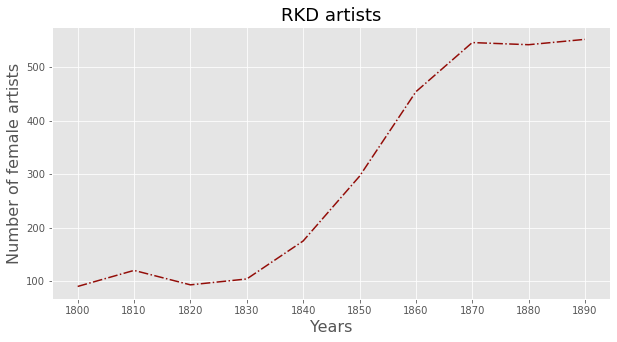

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig = plt.figure( figsize = ( 10, 5))
ax = plt.axes()

ax.plot( counts.index , counts.values , color = '#930d08' , linestyle = 'dashdot')

ax.set_xlabel('Years', size = 16)
ax.set_ylabel('Number of female artists', size = 16 )


ax.set_title( 'RKD artists', size = 18)
plt.xticks(counts.index)

plt.show()

## Data for Piet Mondriaan

In [20]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint = 'https://api.data.netwerkdigitaalerfgoed.nl/datasets/rkd/rkdartists/services/rkdartists-jena/sparql'
query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rkdo: <http://data.rkd.nl/def#>
PREFIX schema: <http://schema.org/>
prefix wd: <http://www.wikidata.org/entity/>
prefix wdt: <http://www.wikidata.org/prop/direct/>

SELECT ?name ?gender ?nationality ?id ?add ?alternate ?pob ?birth_date 
?pod ?death_date ?edu_name  ?title ?image ?event ?event_desc ?event_location ?event_lat  ?event_long  ?event_date 

WHERE {

?artist schema:identifier '56854' .
?artist schema:name ?name .
OPTIONAL { ?artist schema:gender ?gender . } .
OPTIONAL { ?artist schema:nationality ?nationality . } .
OPTIONAL { ?artist schema:identifier ?id . } .
OPTIONAL { ?artist schema:additionalType ?add . } .
OPTIONAL { ?artist schema:alternateName ?alternate . } .

?artist rkdo:Birth ?birth .
OPTIONAL { ?birth schema:location ?pob . } .
OPTIONAL { ?birth schema:startDate ?birth_date  . } .

  
?artist rkdo:Death ?death .
OPTIONAL { ?death schema:location ?pod . } .
OPTIONAL { ?death schema:startDate ?death_date . } .
  
?artist rkdo:Education ?edu .
OPTIONAL { ?edu schema:name ?edu_name. } .
  
?artist schema:event ?event.
OPTIONAL { ?event schema:description ?event_desc . } .
OPTIONAL { ?event schema:location ?event_location . } .
OPTIONAL { ?event schema:latitude ?event_lat . } .
OPTIONAL { ?event schema:longitude ?event_long . } .
OPTIONAL { ?event schema:startDate ?event_date .} .

service <https://query.wikidata.org/bigdata/namespace/wdq/sparql> {

?work wdt:P31 wd:Q3305213;
    wdt:P170 wd:Q151803;
    wdt:P18 ?image;
    wdt:P1476 ?title;
}
  
FILTER (lang(?name) = 'nl')
}

"""


sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
data = sparql.query().convert()


In [21]:
import pandas as pd
import numpy as np 

df = pd.json_normalize(data['results']['bindings'])   

In [22]:
from IPython.core.display import display, HTML


first = df.iloc[0]
print( f"Name: {first['name.value']}" )
print( f"https://rkd.nl/nl/explore/artists/{first['id.value']}" )

print( f"\nGender: {first['gender.value'][first['gender.value'].rindex('/')+1:]}" )
print( f"Date of birth: {first['birth_date.value']}" )
print( f"Date of death: {first['death_date.value']}" )

print('\nAlternative names:')
names = df['alternate.value']
for name in names.drop_duplicates().values:
    print(name)
    
print('\nEducation:')
edu = df['edu_name.value']
for education in edu.drop_duplicates().values:
    print(education)
    

print('\nEvents:')
df['event_duplicated'] = df.duplicated(subset='event_desc.value', keep='first')

events = df[ df['event_duplicated'] == False ]
events = events.sort_values('event_date.value')
for i,row in events.iterrows():
    print( f"{row['event_date.value']}\n{row['event_desc.value']} ")
    

print('\nWorks:')
df['works_duplicated'] = df.duplicated(subset='title.value', keep='first')

works = df[ df['works_duplicated'] == False ]
for i,row in works.iterrows():
    print( f"{row['title.value']}\n")
    display(HTML(f'<img src="{row["image.value"]}" style="width: 200px; " />'))


    

Name: Mondriaan, Piet
https://rkd.nl/nl/explore/artists/56854

Gender: Male
Date of birth: 1872-03-07
Date of death: 1944-02-01

Alternative names:
Mondrian, Piet
Mondriaan, Pieter Cornelis

Education:
Rijksakademie van beeldende kunsten (Amsterdam)

Events:
1897
nan 
1909
also West-Kapelle 
1911
visits Paris for ten days in mid-June (Bois 1994) 
1912-03
lives at avenue du Maine 33 (Bois 1994) 
1912-05
lives at rue du Départ 26 (Bois 1994) 
1919-06-22
due to finding his old studio at 26 rue du Départ occupied by Tour Dones, moves into the vacant studio Kickert had occupied briefly in 1912 in the same building (Bois 1994) 
1919-11-01
moves to a new studio at rue de Coulmiers 5 (Bois 1994) 
1921-10-22
returns to rue du Départ, where he occupies the larger studio of the Stieltjes (Bois 1994) 
1936-03-20
moves into new quarters in the studio building at boulevard Raspail 278 (Bois 1994) 

Works:
Composition II ; Composition 2 avec rouge et bleu



Composition en rouge, bleu et blanc II



Still Life with Sunflower



Stammer Mill with Streaked Sky



Composition with Red, Blue, Yellow, Black, and Gray



Zwartbonte vaars in de weide



Bloeiende appelboom



Apple Tree in Bloom



Boerderij met wasgoed aan de lijn



Chrysanthemum



Rastercompositie 8: dambordcompositie donkere kleuren



Composition No. IV (Compositie No. IV) / Compositie 6



Compositie bomen 2



Composition de lignes et couleur: III (Compositie met lijnen en met kleur: III)



Duin I



Boerderij met hooiberg



Compositie met grijze lijnen



Kindje



Zee na zonsondergang



Spring Sun (Lentezon): Castle Ruin: Brederode



Tableau III: Composition in Oval



Tableau III: compositie in ovaal



Oostzijdse molen bij avond



Arbre



The Tree A



The Winkel Mill, Pointillist Version



Willow Grove: Impression of Light and Shadow



Wilgen met zon (studie olieverf)



Koeien in de wei



Landschap bij maanlicht



Ven bij Saasveld



Korenschoven in het veld



Boerderij bij Duivendrecht



Boerderij in de avond



Isar Harlemia



Veld met bomen bij avond



Het Singel, Amsterdam



Onderschildering voor land en lucht



Boerderij te Blaricum



Werf te Durgerdam



Bomen langs het Gein



Avondstemming aan de Amstel (De Omval)



Vrouw bij boerderij



Onderschildering voor avondlandschap



Veld met bomengroep bij avond II



Schaapskooi in de avond



Veld met bomengroep bij avond I



Boerderij Geinrust in de nevel



Stervende zonnebloem I



Stervende zonnebloem II



Zeegezicht



Duin II



Aäronskelk; Blauwe bloem



Aäronskelken



Zeeuwsche boer



Kerk te Oostkapelle



Duinlandschap



Paysage (Landschap)



Landschap met bomen



Portret van een dame



Het grote naakt



Compositie bomen 1



Tableau No. 4 (Schilderij No. 4) / Composition No.VIII / Compositie 3



Compositie in ovaal met kleurvlakken 2



Molen bij avond



Stier



Gezicht op een rij huizen met een landweg



Sloot met brug



Knotwilgen



Boom



Twee aronskelken



Compositie met rood, blauw, zwart, geel en grijs



Boerderij



Kopie naar de Pietà van Villeneuve-Lès-Avignon door Enguerrand Quarton



Oostzijdse molen



Boerderij Landzicht



Duinen bij Domburg



Compositie met rood, zwart, geel, blauw en grijs



Huisje bij zon



De rode wolk



Slootje bij boerderij Landzicht



Avond aan het Gein



Portret van D.J. Hulshoff Pol



Portret van J.P.G. Hulshoff Pol



Avondlandschap



Boerderij met boerin aan de was



Knotwilgenbosje langs het Gein



Eenzame boom aan het Gein



Compositie no. 3 met kleurvakjes



Boerderij aan een sloot met bomen



Compositie met gele lijnen



Boomgaard met kippen



Groot landschap



Avondlandschap aan het Gein



Landschap met bomen aan het Gein



Molen achter hoge bomen



Gezicht op de Schinkelbuurt



Het Gein: Bomen aan het water



Duin IV



Compositie met rood, geel, zwart, blauw en grijs



Boerderij met bomen



Weidelandschap met koeien



Boerderij, Brabant



Dorpsgezicht



Avond



De Kostverlorenvaart



Twee chrysanten



Wilgen aan het Gein



Baggermolen



Weide met koeien



Bos



Bloeiende bomen



Landweg met huizen



Studie naar twee koeien



Mijmering



Roodbonte vaars in de weide



Twee figuren



Vrouwen met kind voor boerderij



Sloot met twee wilgen



Boerenhoeve aan een sloot



Bij de ossenstal



Schuur te Nistelrode



Het Gein: bomen aan het water



Boerderijen met op de voorgrond een hek



Huis aan het water met vrouw aan de was



Avondlandschap met koeien



De Koninklijke Waskaarsenfabriek



De Boerenwetering



Boerderij met wilgen aan het Gein



Bleekerij aan het Gein



Boerderij tussen eikenbomen



Wilgenbosje



Tableau No. 3: Composition in Oval



Tableau no. 3: compositie in ovaal



Stilleven met haringen



Still Life with Herrings



Painting No. II / Composition No. XV / Composition 4



Schilderij no. II / Compositie no. XV / Compositie 4



Composition with Yellow, Red, Black, Blue, and Gray



Compositie met geel, rood, zwart, blauw en grijs



Composition No.IV, with Red, Blue, and Yellow



Compositie no. IV, met rood, blauw en geel



Farm Setting, Four Tall Trees in the Foreground I



Boerderij met vier hoge bomen in de voorgrond I



Lozenge Composition with Two Lines



Ruitvormige compositie met twee lijnen



Mannelijk naakt



Sun, Church in Zeeland; Zoutelande Church Facade



Composition B (No.II) with Red



No. VI / Composition No.II



Fox Trot B, with Black, Red, Blue, and Yellow



Fox Trot A



By the Sea



Victory Boogie Woogie



Molen aan 't Gein



Broadway Boogie Woogie



De rode boom



De grijze boom



Tableau I (Schilderij I)



Composition with Yellow, Blue and Red



Oostzijdse Mill along the River Gein by Moonlight



Oostzijdse molen aan het Gein bij maanlicht



Composition: No. III, with Red, Yellow, and Blue



Compositie: no. III, met rood, geel en blauw



Apple Tree, Pointillist Version



Composition with Large Blue Plane, Red, Black, Yellow, and Gray



Windmill



Farm Near Duivendrecht, in the Evening



Vuurtoren bij Westkapelle



Evolutie



Stilleven met gemberpot 2



Molen; Molen bij zonlicht



Molen bij Domburg



Molen; De rode molen



Bomen aan het Gein: opkomende maan



Devotie



Bosch; Bos bij Oele



Kerk te Domburg



Zeeuwsche kerktoren



Metamorfose



Lozenge Composition with Yellow, Black, Blue, Red, and Gray



Windmolen



Zelfportret



Rastercompositie 9: dambordcompositie heldere kleuren



Duin III



Zomer, duin in Zeeland



Stilleven met gemberpot 1



Windmill with Summerhouse II



Oostzijdse molen in maanlicht



Composition



Tableau No. IV; Lozenge Composition with Red, Gray, Blue, Yellow, and Black



Farm near Duivendrecht



Composition (No. 1) Gray-Red



Composition with Blue, Yellow, and Red



grande composizione A con nero, rosso, grigio, giallo e blu



Geschoten haas

